<a href="https://colab.research.google.com/github/RishithaAppikonda/Legal-Text-Classification/blob/main/ML%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

!pip install torchtext --upgrade --quiet
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler,Dataset
import torch.optim as optim

!pip install stop-words
from stop_words import get_stop_words
import nltk
#nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
!pip install gensim

from gensim.models import Word2Vec, KeyedVectors, FastText

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


## EDA

In [ ]:
df = pd.read_csv("/content/legal_text_classification.csv")

In [ ]:
df

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...
...,...,...,...,...
24980,Case25203,cited,Reches Pty Ltd v Tadiran Pty Ltd (1998) 85 FCR...,That is not confined to persons who control th...
24981,Case25204,cited,Sir Lindsay Parkinson &amp; Co Ltd v Triplan L...,Once the threshold prescribed by s 1335 is sat...
24982,Case25205,cited,Spiel v Commodity Brokers Australia Pty Ltd (I...,Once the threshold prescribed by s 1335 is sat...
24983,Case25206,distinguished,"Tullock Ltd v Walker (Unreported, Supreme Cour...",Given the extent to which Deumer stands to gai...


In [ ]:
df.describe()

,case_id,case_outcome,case_title,case_text
count,24985,24985,24985,24809
unique,24985,10,18581,17920
top,Case25207,cited,Minister for Immigration and Ethnic Affairs v ...,submitted that this Court should hold that the...
freq,1,12219,70,42


In [ ]:
df.case_outcome.unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [ ]:
df.case_outcome.value_counts()

,count
case_outcome,
cited,12219
referred to,4384
applied,2448
followed,2256
considered,1712
discussed,1024
distinguished,608
related,113
affirmed,113


Видна проблема сильного дизбаланса классов

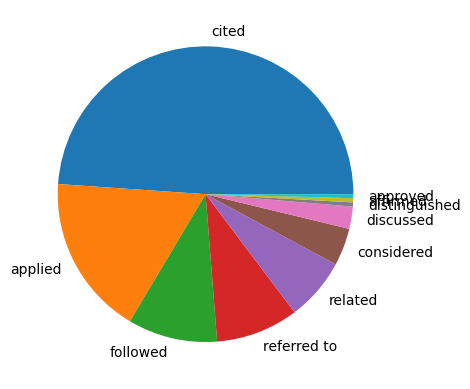

In [ ]:
plt.pie(df.case_outcome.value_counts(),labels=df.case_outcome.unique());

In [ ]:
df.isna().sum()

,0
case_id,0
case_outcome,0
case_title,0
case_text,176


In [ ]:
df = df.fillna('')

In [ ]:
df.isna().sum()

,0
case_id,0
case_outcome,0
case_title,0
case_text,0


In [ ]:
df['case_text_sum'] = df["case_title"] + df["case_text"]

In [ ]:
mask = df["case_text_sum"].str.contains(r"https?://\S+|www\.\S+")
res = df.loc[mask]

In [ ]:
res.case_text[9]

'Hexal Australia Pty Ltd v Roche Therapeutics Inc (2005) 66 IPR 325, the likelihood of irreparable harm was regarded by Stone J as, indeed, a separate element that had to be established by an applicant for an interlocutory injunction. Her Honour cited the well-known passage from the judgment of Mason ACJ in Castlemaine Tooheys Ltd v South Australia [1986] HCA 58 ; (1986) 161 CLR 148 (at 153) as support for that proposition. Had it not been for the fact that there will be a speedy trial of this matter, which Stone J regarded as a relevant consideration in Hexal v Roche (at [78]), I might have been inclined to grant some, at least, of the orders sought by CSL. I will give the parties an opportunity to be heard in relation to the matter of costs. I certify that the preceding one hundred and seven (107) numbered paragraphs are a true copy of the Reasons for Judgment herein of the Honourable Justice Weinberg. Associate: Dated: 3 October 2006 Counsel for the Applicant: Mr B.N. Caine SC and D

In [ ]:
le = LabelEncoder()
df['case_outcome_num'] = le.fit_transform(df.case_outcome)

## Preproccessing

### Cleaning data

In [ ]:
# Чистка текста
def cleaning(inp_str):
    marks ='''!()-[]{};?@#$%:'"\,|./^&;*_1234567890'''
    inp_str = inp_str.lower()
    inp_str = inp_str.replace(r'https?://\S+|www\.\S+', '')
    for x in inp_str:
        if x in marks:
            inp_str = inp_str.replace(x, "")
    inp_str = inp_str.replace('url','').replace('privacy policy','')\
                     .replace('disclaimers','').replace('disclaimer','').replace('copyright policy','')
    return inp_str
def beauty_df(df,col='case_text_sum'):
    return df[col].apply(lambda x: cleaning(x)).str.split().apply(lambda x: " ".join(x))
def split_df(df,col='case_text_sum',beauty=True):
    if beauty:
        return beauty_df(df,col).str.split()
    else:
        df[col].str.split()
def df_to_dict_unique(df,col='case_text_sum'):
    a = dict()
    df = split_df(df,'case_text_sum')
    for i in df:
        for j in i:
            if j not in a.keys():
                a[j] = 0
            else:
                a[j] += 1
    return a

In [ ]:
stop_words = get_stop_words('en')

In [ ]:
splited_df = split_df(df,col='case_text_sum',beauty=True)

In [ ]:
wsw = splited_df.apply(lambda x:[i for i in x if i not in stop_words and len(i) > 2])
wsw

,case_text_sum
0,"[alpine, hardwood, aust, pty, ltd, hardys, pty..."
1,"[black, lipovac, fca, alr, general, principles..."
2,"[colgate, palmolive, cussons, pty, ltd, fcr, o..."
3,"[dais, studio, pty, ltd, bullett, creative, pt..."
4,"[martens, australia, pty, ltd, figgins, holdin..."
...,...
24980,"[reches, pty, ltd, tadiran, pty, ltd, fcr, con..."
24981,"[sir, lindsay, parkinson, amp, ltd, triplan, l..."
24982,"[spiel, commodity, brokers, australia, pty, lt..."
24983,"[tullock, ltd, walker, unreported, supreme, co..."


### Stemming and Lemmatization

In [ ]:
def get_lem_word(word):
    wnl = WordNetLemmatizer()
    return wnl.lemmatize(word, pos="v")
def get_stm_word(word):
    ps = PorterStemmer()
    return ps.stem(word)

In [ ]:
with_lem = wsw.apply(lambda x: [get_lem_word(i) for i in x])
with_lem

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
with_stm = wsw.apply(lambda x: [get_stm_word(i) for i in x])
with_stm

### train test split

In [ ]:
train_stm, test_stm, y_train_stm, y_test_stm = train_test_split(with_stm, df['case_outcome_num'], test_size=0.1)
train_lem, test_lem, y_train_lem, y_test_lem  = train_test_split(with_lem, df['case_outcome_num'], test_size=0.1)

In [ ]:
train_stm = train_stm.sort_index().reset_index().drop('index',axis=1)
test_stm = test_stm.sort_index().reset_index().drop('index',axis=1)
train_lem = train_lem.sort_index().reset_index().drop('index',axis=1)
test_lem = test_lem.sort_index().reset_index().drop('index',axis=1)
y_train_stm = y_train_stm.sort_index().reset_index().drop('index',axis=1)
y_test_stm = y_test_stm.sort_index().reset_index().drop('index',axis=1)
y_train_lem = y_train_lem.sort_index().reset_index().drop('index',axis=1)
y_test_lem = y_test_lem.sort_index().reset_index().drop('index',axis=1)

In [ ]:
train_stm_ser = train_stm.case_text_sum
test_stm_ser = test_stm.case_text_sum
train_lem_ser = train_lem.case_text_sum
test_lem_ser = test_lem.case_text_sum

## Word embeddings

### CountVectorizer

#### stemming

In [ ]:
count_vectorizer_stm = CountVectorizer(max_features=2500)
count_vectors_stm = count_vectorizer_stm.fit_transform(train_stm_ser.apply(' '.join))

In [ ]:
x_train_stm_count_vec = count_vectors_stm.toarray()
x_test_stm_count_vec = count_vectorizer_stm.transform(test_stm_ser.apply(' '.join)).toarray()

#### lemmatization

In [ ]:
count_vectorizer_lem = CountVectorizer(max_features=2500)
count_vectors_lem = count_vectorizer_lem.fit_transform(train_lem_ser.apply(' '.join))

In [ ]:
x_train_lem_count_vec = count_vectors_lem.toarray()
x_test_lem_count_vec = count_vectorizer_lem.transform(test_lem_ser.apply(' '.join)).toarray()

### TF-IDF

#### stemming

In [ ]:
tf_idf_vectorizer_stm = TfidfVectorizer(max_features=2500)
tf_idf_vectors_stm = tf_idf_vectorizer_stm.fit_transform(train_stm_ser.apply(' '.join))
tf_idf_vectors_stm.shape

In [ ]:
tf_idf_vectorizer_stm.get_feature_names_out()

In [ ]:
x_train_stm_tf_idf = (tf_idf_vectors_stm.toarray() * 100).astype('int64')
x_test_stm_tf_idf = (tf_idf_vectorizer_stm.transform(test_stm.case_text_sum.apply(' '.join)).toarray()* 100).astype('int64')

Для демонстрации изменений

In [ ]:
x_train_stm_tf_idf_ = tf_idf_vectors_stm.toarray()
x_test_stm_tf_idf_ = tf_idf_vectorizer_stm.transform(test_stm.case_text_sum.apply(' '.join)).toarray()

#### lemmatization

In [ ]:
tf_idf_vectorizer_lem = TfidfVectorizer(max_features=2500)
tf_idf_vectors_lem = tf_idf_vectorizer_lem.fit_transform(train_lem_ser.apply(' '.join))
tf_idf_vectors_lem.shape

In [ ]:
tf_idf_vectorizer_lem.get_feature_names_out()

In [ ]:
x_train_lem_tf_idf = (tf_idf_vectors_lem.toarray()* 100).astype('int64')
x_test_lem_tf_idf = (tf_idf_vectorizer_lem.transform(test_lem_ser.apply(' '.join)).toarray()* 100).astype('int64')

Для демонстрации изменений

In [ ]:
x_train_lem_tf_idf_ = tf_idf_vectors_lem.toarray()
x_test_lem_tf_idf_ = tf_idf_vectorizer_lem.transform(test_lem_ser.apply(' '.join)).toarray()

### Word2Vec

In [ ]:
size_len_ = 1000

In [ ]:
def word_vector(model,tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0

    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1
        except KeyError:
            continue

    if count != 0:
        vec /= count

    return vec

#### stemming

In [ ]:
w2v_model_stm = Word2Vec(train_stm_ser
                     , vector_size=size_len_
                     , min_count=3
                     , workers=4)
w2v_model_stm.build_vocab(train_stm_ser)
w2v_model_stm.train(train_stm_ser
                , total_examples= w2v_model_stm.corpus_count
                , epochs=w2v_model_stm.epochs)

In [ ]:
w2v_model_stm.wv.key_to_index['week']

In [ ]:
w2v_model_stm.wv.vectors.shape

In [ ]:
w2v_model_stm.wv.most_similar(positive='world', topn=7)

In [ ]:
train_stm_word_vec = np.zeros((len(train_stm_ser), size_len_))
test_stm_word_vec = np.zeros((len(test_stm_ser), size_len_))
for i in range(len(train_stm_ser)):
    train_stm_word_vec[i,:] = word_vector(w2v_model_stm,train_stm_ser[i], size_len_)
for i in range(len(test_stm_ser)):
    test_stm_word_vec[i,:] = word_vector(w2v_model_stm,test_stm_ser[i], size_len_)
train_stm_word_vec = (train_stm_word_vec*100).astype('int64')
test_stm_word_vec = (test_stm_word_vec*100).astype('int64')
print(train_stm_word_vec.shape)
print(test_stm_word_vec.shape)

#### lemmatization

In [ ]:
w2v_model_lem = Word2Vec(train_lem_ser
                     , vector_size=1000
                     , min_count=3
                     , workers=4)
w2v_model_lem.build_vocab(train_lem_ser)

In [ ]:
w2v_model_lem.train(train_lem_ser
                , total_examples= w2v_model_lem.corpus_count
                , epochs=w2v_model_lem.epochs)

In [ ]:
w2v_model_lem.wv.vectors.shape

In [ ]:
w2v_model_lem.wv.most_similar(positive='world', topn=7)

In [ ]:
train_lem_word_vec = np.zeros((len(train_lem_ser), 1000))
test_lem_word_vec = np.zeros((len(test_lem_ser), 1000))
for i in range(len(train_lem_ser)):
    train_lem_word_vec[i,:] = word_vector(w2v_model_lem,train_lem_ser[i], 1000)
for i in range(len(test_lem_ser)):
    test_lem_word_vec[i,:] = word_vector(w2v_model_lem,test_lem_ser[i], 1000)
train_lem_word_vec = (train_lem_word_vec * 100).astype('int64')
test_lem_word_vec = (test_lem_word_vec*100).astype('int64')
print(train_lem_word_vec.shape)
print(test_lem_word_vec.shape)

### FastText

min_count (int, optional) – The model ignores all words with total frequency lower than this.

vector_size (int, optional) – Dimensionality of the word vectors.

window (int, optional) – The maximum distance between the current and predicted word within a sentence.

#### stemming

In [ ]:
ft_model_stm = FastText(vector_size=500, window=3, min_count=2)
ft_model_stm.build_vocab(train_stm_ser)
ft_model_stm.train(train_stm_ser
                   ,total_examples=len(train_stm_ser)
                   ,epochs=10)

In [ ]:
ft_model_stm.wv['world']

In [ ]:
ft_model_stm.wv.most_similar(positive='piece', topn=7)

In [ ]:
train_stm_ft = np.zeros((len(train_stm_ser), 500))
test_stm_ft = np.zeros((len(test_stm_ser), 500))
for i in range(len(train_stm_ser)):
    train_stm_ft[i,:] = word_vector(ft_model_stm,train_stm_ser[i], 500)
for i in range(len(test_stm_ser)):
    test_stm_ft[i,:] = word_vector(ft_model_stm,test_stm_ser[i], 500)
train_stm_ft = (train_stm_ft*100).astype('int64')
test_stm_ft = (test_stm_ft*100).astype('int64')
print(train_stm_ft.shape)
print(test_stm_ft.shape)

#### lemmatization

In [ ]:
ft_model_lem = FastText(vector_size=500, window=3, min_count=2)
ft_model_lem.build_vocab(train_lem_ser)
ft_model_lem.train(train_lem_ser
                   ,total_examples=len(train_lem_ser)
                   ,epochs=10)

In [ ]:
ft_model_lem.wv['world']

In [ ]:
ft_model_lem.wv.most_similar(positive='piece', topn=7)

In [ ]:
train_lem_ft = np.zeros((len(train_lem_ser), 500))
test_lem_ft = np.zeros((len(test_lem_ser), 500))
for i in range(len(train_lem_ser)):
    train_lem_ft[i,:] = word_vector(ft_model_lem,train_lem_ser[i], 500)
for i in range(len(test_lem_ser)):
    test_lem_ft[i,:] = word_vector(ft_model_lem,test_lem_ser[i], 500)
train_lem_ft = (train_lem_ft*100).astype('int64')
test_lem_ft = (test_lem_ft*100).astype('int64')
print(train_lem_ft.shape)
print(test_lem_ft.shape)

## Logistic Regression

In [ ]:
def compute_metrics(y_test, pred, first_lines=None):
    if first_lines != None:
        for i in range(first_lines):
            print("\n" + first_line)
    print(f"Accuracy: {round(accuracy_score(y_test, pred)*100, 3)}%")
    print(f"F1 score: {round(f1_score(y_test, pred, average='macro')*100, 3)}%")

### Count vectorizer with stemming

In [ ]:
lr_model_stm_count_vec = LogisticRegression()
lr_model_stm_count_vec.fit(x_train_stm_count_vec, y_train_stm)

In [ ]:
lr_pred_stm_count_vec_ = lr_model_stm_count_vec.predict(x_train_stm_count_vec)
sns.heatmap(confusion_matrix(y_train_stm, lr_pred_stm_count_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, lr_pred_stm_count_vec_)

In [ ]:
lr_pred_stm_count_vec = lr_model_stm_count_vec.predict(x_test_stm_count_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, lr_pred_stm_count_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, lr_pred_stm_count_vec)

### Count vectorizer with lemmatization

In [ ]:
lr_model_lem_count_vec = LogisticRegression()
lr_model_lem_count_vec.fit(x_train_lem_count_vec, y_train_lem)

In [ ]:
lr_pred_lem_count_vec_ = lr_model_lem_count_vec.predict(x_train_lem_count_vec)
sns.heatmap(confusion_matrix(y_train_lem, lr_pred_lem_count_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, lr_pred_lem_count_vec_)

In [ ]:
lr_pred_lem_count_vec = lr_model_lem_count_vec.predict(x_test_lem_count_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, lr_pred_lem_count_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, lr_pred_lem_count_vec)

### TF IDF with stemming

In [ ]:
lr_model_stm_tf_idf = LogisticRegression()
lr_model_stm_tf_idf.fit(x_train_stm_tf_idf, y_train_stm)

In [ ]:
lr_pred_stm_tf_idf_ = lr_model_stm_tf_idf.predict(x_train_stm_tf_idf)
sns.heatmap(confusion_matrix(y_train_stm, lr_pred_stm_tf_idf_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, lr_pred_stm_tf_idf_)

In [ ]:
lr_pred_stm_tf_idf = lr_model_stm_tf_idf.predict(x_test_stm_tf_idf)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, lr_pred_stm_tf_idf)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, lr_pred_stm_tf_idf)

#### Без перевода в целые

In [ ]:
lr_model_stm_tf_idf_o = LogisticRegression()
lr_model_stm_tf_idf_o.fit(x_train_stm_tf_idf_, y_train_stm)

In [ ]:
lr_pred_stm_tf_idf_o = lr_model_stm_tf_idf_o.predict(x_train_stm_tf_idf_)
sns.heatmap(confusion_matrix(y_train_stm, lr_pred_stm_tf_idf_o)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, lr_pred_stm_tf_idf_o)

In [ ]:
lr_pred_stm_tf_idf_t = lr_model_stm_tf_idf_o.predict(x_test_stm_tf_idf_)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, lr_pred_stm_tf_idf_t)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, lr_pred_stm_tf_idf_t)

### TF IDF with lemmatization

In [ ]:
lr_model_lem_tf_idf = LogisticRegression()
lr_model_lem_tf_idf.fit(x_train_lem_tf_idf, y_train_lem)

In [ ]:
lr_pred_lem_tf_idf_ = lr_model_lem_tf_idf.predict(x_train_lem_tf_idf)
sns.heatmap(confusion_matrix(y_train_lem, lr_pred_lem_tf_idf_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, lr_pred_lem_tf_idf_)

In [ ]:
lr_pred_lem_tf_idf = lr_model_lem_tf_idf.predict(x_test_lem_tf_idf)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, lr_pred_lem_tf_idf)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, lr_pred_lem_tf_idf)

### Word2Vec with stemming

In [ ]:
lr_model_stm_word_vec = LogisticRegression()
lr_model_stm_word_vec.fit(train_stm_word_vec, y_train_stm)

In [ ]:
lr_pred_stm_word_vec_ = lr_model_stm_word_vec.predict(train_stm_word_vec)
sns.heatmap(confusion_matrix(y_train_stm, lr_pred_stm_word_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, lr_pred_stm_word_vec_)

In [ ]:
lr_pred_stm_word_vec = lr_model_stm_word_vec.predict(test_stm_word_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, lr_pred_stm_word_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, lr_pred_stm_word_vec)

### Word2Vec with lemmatization

In [ ]:
lr_model_lem_word_vec = LogisticRegression()
lr_model_lem_word_vec.fit(train_lem_word_vec, y_train_lem)

In [ ]:
lr_pred_lem_word_vec_ = lr_model_lem_word_vec.predict(train_lem_word_vec)
sns.heatmap(confusion_matrix(y_train_lem, lr_pred_lem_word_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, lr_pred_lem_word_vec_)

In [ ]:
lr_pred_lem_word_vec = lr_model_lem_word_vec.predict(test_lem_word_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, lr_pred_lem_word_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, lr_pred_lem_word_vec)

### FastText with stemming

In [ ]:
lr_model_stm_ft = LogisticRegression()
lr_model_stm_ft.fit(train_stm_ft, y_train_stm)

In [ ]:
lr_pred_stm_ft_ = lr_model_stm_ft.predict(train_stm_ft)
sns.heatmap(confusion_matrix(y_train_stm, lr_pred_stm_ft_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, lr_pred_stm_ft_)

In [ ]:
lr_pred_stm_ft = lr_model_stm_ft.predict(test_stm_ft)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, lr_pred_stm_ft)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, lr_pred_stm_ft)

### FastText with lemmatization

In [ ]:
lr_model_lem_ft = LogisticRegression()
lr_model_lem_ft.fit(train_lem_ft, y_train_lem)

In [ ]:
lr_pred_lem_ft_ = lr_model_lem_ft.predict(train_lem_ft)
sns.heatmap(confusion_matrix(y_train_lem, lr_pred_lem_ft_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, lr_pred_lem_ft_)

In [ ]:
lr_pred_lem_ft = lr_model_lem_ft.predict(test_lem_ft)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, lr_pred_lem_ft)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, lr_pred_lem_ft)

## KNN

### Count vectorizer with stemming

In [ ]:
knn_model_stm_count_vec = KNeighborsClassifier(n_neighbors=10)
knn_model_stm_count_vec.fit(x_train_stm_count_vec, y_train_stm)

In [ ]:
knn_pred_stm_ = knn_model_stm_count_vec.predict(x_train_stm_count_vec)
sns.heatmap(confusion_matrix(y_train_stm, knn_pred_stm_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, knn_pred_stm_)

In [ ]:
knn_pred_stm = knn_model_stm_count_vec.predict(x_test_stm_count_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, knn_pred_stm)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, knn_pred_stm)

### Count vectorizer with lemmatization

In [ ]:
knn_model_lem_count_vec = KNeighborsClassifier(n_neighbors=10)
knn_model_lem_count_vec.fit(x_train_lem_count_vec, y_train_lem)

In [ ]:
knn_pred_lem_count_vec_ = knn_model_lem_count_vec.predict(x_train_lem_count_vec)
sns.heatmap(confusion_matrix(y_train_lem, knn_pred_lem_count_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, knn_pred_lem_count_vec_)

In [ ]:
knn_pred_lem_count_vec = knn_model_lem_count_vec.predict(x_test_lem_count_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, knn_pred_lem_count_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, knn_pred_lem_count_vec)

### TF IDF with stemming

In [ ]:
knn_model_stm_tf_idf = KNeighborsClassifier(n_neighbors=10)
knn_model_stm_tf_idf.fit(x_train_stm_tf_idf, y_train_stm)

In [ ]:
knn_pred_stm_tf_idf_ = knn_model_stm_tf_idf.predict(x_train_stm_tf_idf)

In [ ]:
sns.heatmap(confusion_matrix(y_train_stm, knn_pred_stm_tf_idf_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, knn_pred_stm_tf_idf_)

In [ ]:
knn_pred_stm_tf_idf = knn_model_stm_tf_idf.predict(x_test_stm_tf_idf)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, knn_pred_stm_tf_idf)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, knn_pred_stm_tf_idf)

### TF IDF with lemmatization

In [ ]:
knn_model_lem_tf_idf = KNeighborsClassifier(n_neighbors=10)
knn_model_lem_tf_idf.fit(x_train_lem_tf_idf, y_train_lem)

In [ ]:
knn_pred_lem_tf_idf_ = knn_model_lem_tf_idf.predict(x_train_lem_tf_idf)
sns.heatmap(confusion_matrix(y_train_lem, knn_pred_lem_tf_idf_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, knn_pred_lem_tf_idf_)

In [ ]:
knn_pred_lem_tf_idf = knn_model_lem_tf_idf.predict(x_test_lem_tf_idf)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, knn_pred_lem_tf_idf)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, knn_pred_lem_tf_idf)

### Word2Vec with stemming

In [ ]:
knn_model_stm_word_vec = KNeighborsClassifier(n_neighbors=10)
knn_model_stm_word_vec.fit(train_stm_word_vec, y_train_stm)

In [ ]:
knn_pred_stm_word_vec_ = knn_model_stm_word_vec.predict(train_stm_word_vec)
sns.heatmap(confusion_matrix(y_train_stm, knn_pred_stm_word_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, knn_pred_stm_word_vec_)

In [ ]:
knn_pred_stm_word_vec = knn_model_stm_word_vec.predict(test_stm_word_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, knn_pred_stm_word_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, knn_pred_stm_word_vec)

### Word2Vec with lemmatization

In [ ]:
knn_model_lem_word_vec = KNeighborsClassifier(n_neighbors=10)
knn_model_lem_word_vec.fit(train_lem_word_vec, y_train_lem)

In [ ]:
knn_pred_lem_word_vec_ = knn_model_lem_word_vec.predict(train_lem_word_vec)
sns.heatmap(confusion_matrix(y_train_lem, knn_pred_lem_word_vec_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, knn_pred_lem_word_vec_)

In [ ]:
knn_pred_lem_word_vec = knn_model_lem_word_vec.predict(test_lem_word_vec)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, knn_pred_lem_word_vec)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, knn_pred_lem_word_vec)

### FastText with stemming

In [ ]:
knn_model_stm_ft = KNeighborsClassifier(n_neighbors=10)
knn_model_stm_ft.fit(train_stm_ft, y_train_stm)

In [ ]:
knn_pred_stm_ft_ = knn_model_stm_ft.predict(train_stm_ft)
sns.heatmap(confusion_matrix(y_train_stm, knn_pred_stm_ft_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_stm, knn_pred_stm_ft_)

In [ ]:
knn_pred_stm_ft = knn_model_stm_ft.predict(test_stm_ft)

In [ ]:
sns.heatmap(confusion_matrix(y_test_stm, knn_pred_stm_ft)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_stm, knn_pred_stm_ft)

### FastText with lemmatization

In [ ]:
knn_model_lem_ft = KNeighborsClassifier(n_neighbors=10)
knn_model_lem_ft.fit(train_lem_ft, y_train_lem)

In [ ]:
knn_pred_lem_ft_ = knn_model_lem_ft.predict(train_lem_ft)
sns.heatmap(confusion_matrix(y_train_lem, knn_pred_lem_ft_)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_train_lem, knn_pred_lem_ft_)

In [ ]:
knn_pred_lem_ft = knn_model_lem_ft.predict(test_lem_ft)

In [ ]:
sns.heatmap(confusion_matrix(y_test_lem, knn_pred_lem_ft)
            , cmap='YlGnBu', linewidths=1, annot=True
            , square=True, fmt='d', cbar=False)

In [ ]:
compute_metrics(y_test_lem, knn_pred_lem_ft)

## Self-made models

### CNN

In [ ]:
class CNNModel_v1(nn.Module):
    def __init__(self, embed_size=250, hidden_size=50, num_classes=10):
        super(CNNModel_v1,self).__init__()
        self.embeddings = nn.Embedding(embed_size, embedding_dim=embed_size)
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
        )
        self.cl = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = self.embeddings(x)
        x = self.cnn(x)
        prediction = self.cl(x)
        return prediction

In [ ]:
def text_to_tensor(text, vectorizer,emp_base):
    new_tensor = list()
    if emp_base:
        vocab_dict = vectorizer.vocabulary_
        for word in text.split():
            word_id = vocab_dict.get(word, 0)
            new_tensor.append(word_id)
    else:
        for word in text.split():
            try:
                word_id = vectorizer.wv.key_to_index[word]
            except KeyError:
                word_id = 0
            new_tensor.append(word_id)
    return new_tensor

def collate_batch(batch):
    label_list, text_list = [], []
    label_pipeline = lambda x: int(x)
    for (_text, _label,_vectorizer,_emp_base) in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(text_to_tensor(_text, _vectorizer,_emp_base))
    if _emp_base:
        max_len = len(_vectorizer.vocabulary_)
    else:
        max_len = _vectorizer.vector_size
    matrix = np.full((len(text_list), max_len), 0)
    for i, tensor in enumerate(text_list):
            matrix[i, :len(tensor[:max_len])] = tensor[:max_len]
    text_tensor = torch.tensor(matrix, dtype=torch.int64)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return  text_tensor.to(device), label_list.to(device)


def train(model,train_dataloader,optimizer,criterion):
    model.train()
    total_acc, total_count = 0, 0
    batch_losses = []
    for idx, (text, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        total_acc += (output.argmax(1) == label).sum().item()
        total_count += label.size(0)
        batch_losses.append(loss.item())
    model.eval()
    train_loss = np.mean(batch_losses)
    train_acc = 100 * total_acc/total_count


    return train_loss, train_acc

In [ ]:
def calc_model(self_model,df_dict,vectorizer,emb_base=True,epoch=20,df_type='stm',max_len=250,hidden_len=50):
    model = self_model(max_len,hidden_len).to(device)
    print(model)

    df_string =  pd.DataFrame(df_dict.apply(" ".join))
    if df_type == 'stm':
        df_string['case_outcome_num'] = y_train_stm['case_outcome_num']
    elif df_type == 'lem':
        df_string['case_outcome_num'] = y_train_lem['case_outcome_num']
    else:
        print("Error")
        return
    df_string['vectorizer'] = vectorizer
    df_string['emb_base'] = emb_base

    train_dataloader = DataLoader(df_string.values, batch_size=64, shuffle=True, collate_fn=collate_batch)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    current_loss = 0
    current_acc = 0
    all_losses = []
    acc_list = []

    for i in range(epoch):
        print(f'Эпоха {i+1}')
        loss, acc = train(model,train_dataloader,optimizer,criterion)
        current_loss += loss
        current_acc += acc
        print('Current loss:', current_loss)
        print('Current accuracy:', current_acc)
        all_losses.append(current_loss)
        acc_list.append(100 * current_acc)
        current_loss = 0
        current_acc = 0

    plt.figure()
    plt.plot(all_losses)
    plt.show()
    return model,train_dataloader

In [ ]:
def calc_model_metrics(model,dataloader):
    prediction_list = []
    labels_list = []
    with torch.no_grad():
        correct = 0
        num_objs = 0
        for batch in dataloader:
            input_embeds = batch[0].to(device)
            labels = batch[1].to(device)
            prediction = model(input_embeds)
            prediction_list.append(list(np.array(prediction.argmax(1))))
            labels_list.append(list(np.array(labels)))
    lab = []
    pred = []
    for i in range(len(prediction_list)):
        for j in range(len(prediction_list[i])):
            lab.append(labels_list[i][j])
            pred.append(prediction_list[i][j])
    compute_metrics(lab, pred)

In [ ]:
def calc_test_data(df_data, vectorizer,df_type='stm',emb_base=True):
    df_string =  pd.DataFrame(df_data.apply(" ".join))
    if df_type == 'stm':
        df_string['case_outcome_num'] = y_test_stm['case_outcome_num']
    elif df_type == 'lem':
        df_string['case_outcome_num'] = y_test_lem['case_outcome_num']
    else:
        print("Error")
        return
    df_string['vectorizer'] = vectorizer
    df_string['emb_base'] = emb_base

    return DataLoader(df_string.values, batch_size=64, shuffle=True, collate_fn=collate_batch)

Для экспериментов выбраны 250 эмбеддингов для того, чтобы быстрее можно было рассчитать.

In [ ]:
max_len = 250
hidden = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### CNN with count vectorizer and stemming

In [ ]:
count_vectorizer_stm_fm = CountVectorizer(max_features=250)
_ = count_vectorizer_stm_fm.fit_transform(train_stm_ser.apply(' '.join))

In [ ]:
model_250_stm_count_vec,train_dl_stm_count_vec =\
calc_model(CNNModel_v1,train_stm_ser,count_vectorizer_stm_fm,True,20,'stm',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_stm_count_vec,train_dl_stm_count_vec)

In [ ]:
test_dl_stm_count_vec = calc_test_data(test_stm_ser,count_vectorizer_stm_fm,'stm',True)
calc_model_metrics(model_250_stm_count_vec,test_dl_stm_count_vec)

### CNN with count vectorizer and lemmatizations

In [ ]:
count_vectorizer_lem_fm = CountVectorizer(max_features=250)
_ = count_vectorizer_lem_fm.fit_transform(train_lem_ser.apply(' '.join))

In [ ]:
model_250_lem_count_vec,train_dl_lem_count_vec =\
calc_model(CNNModel_v1,train_lem_ser,count_vectorizer_lem_fm,True,20,'lem',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_lem_count_vec,train_dl_lem_count_vec)

In [ ]:
test_dl_lem_count_vec = calc_test_data(test_lem_ser,count_vectorizer_lem_fm,'lem')
calc_model_metrics(model_250_lem_count_vec,test_dl_lem_count_vec)

### CNN with TF-IDF and stemming

In [ ]:
tf_idf_vectorizer_stm_fm = TfidfVectorizer(max_features=250)
_ = tf_idf_vectorizer_stm_fm.fit_transform(train_stm_ser.apply(' '.join))

In [ ]:
model_250_stm_tf_idf, train_dl_stm_tf_idf = \
calc_model(CNNModel_v1,train_stm_ser,tf_idf_vectorizer_stm_fm,True,20,'stm',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_stm_tf_idf,train_dl_stm_tf_idf)

In [ ]:
test_dl_stm_tf_idf = calc_test_data(test_stm_ser,tf_idf_vectorizer_stm_fm,'stm')
calc_model_metrics(model_250_stm_tf_idf,test_dl_stm_tf_idf)

### CNN with TF-IDF and lemmatizations

In [ ]:
tf_idf_vectorizer_lem_fm = TfidfVectorizer(max_features=max_len)
_ = tf_idf_vectorizer_lem_fm.fit_transform(train_lem_ser.apply(' '.join))

In [ ]:
model_250_lem_tf_idf, train_dl_lem_tf_idf = \
calc_model(CNNModel_v1,train_lem_ser,tf_idf_vectorizer_lem_fm,True,20,'lem',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_lem_tf_idf,train_dl_lem_tf_idf)

In [ ]:
test_dl_lem_tf_idf = calc_test_data(test_lem_ser,tf_idf_vectorizer_lem_fm,'lem')
calc_model_metrics(model_250_lem_tf_idf,test_dl_lem_tf_idf)

### CNN with Word2Vec and stemming

In [ ]:
w2v_model_stm_fm = Word2Vec(train_stm_ser
                     , vector_size=max_len
                     , min_count=3
                     , workers=4
                     , max_final_vocab=max_len)
w2v_model_stm_fm.build_vocab(train_stm_ser)
w2v_model_stm_fm.train(train_stm_ser
                , total_examples= w2v_model_stm_fm.corpus_count
                , epochs=w2v_model_stm_fm.epochs)

In [ ]:
model_250_stm_w2v, train_dl_stm_w2v = \
calc_model(CNNModel_v1,train_stm_ser,w2v_model_stm_fm,False,20,'stm',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_stm_w2v,train_dl_stm_w2v)

In [ ]:
test_dl_stm_w2v = calc_test_data(test_stm_ser,w2v_model_stm_fm,'stm',False)
calc_model_metrics(model_250_stm_w2v,test_dl_stm_w2v)

### CNN with Word2Vec and lemmatizations

In [ ]:
w2v_model_lem_fm = Word2Vec(train_lem_ser
                            ,vector_size=max_len
                            ,min_count=3
                            ,workers=4
                            ,max_final_vocab=max_len)
w2v_model_lem_fm.build_vocab(train_lem_ser)
w2v_model_lem_fm.train(train_lem_ser
                , total_examples= w2v_model_lem_fm.corpus_count
                , epochs=w2v_model_lem_fm.epochs)

In [ ]:
model_250_lem_w2v, train_dl_lem_w2v = \
calc_model(CNNModel_v1,train_lem_ser,w2v_model_lem_fm,False,20,'lem',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_lem_w2v,train_dl_lem_w2v)

In [ ]:
test_dl_lem_w2v = calc_test_data(test_lem_ser,w2v_model_lem_fm,'lem',False)
calc_model_metrics(model_250_lem_w2v,test_dl_lem_w2v)

### CNN with FastText and stemming

In [ ]:
ft_model_stm_fm = FastText(train_stm_ser
                        ,vector_size=max_len
                        ,window=3
                        ,min_count=2
                        ,max_final_vocab=max_len)
ft_model_stm_fm.build_vocab(train_stm_ser)
ft_model_stm_fm.train(train_stm_ser
                   ,total_examples=ft_model_stm_fm.corpus_count
                   ,epochs=ft_model_stm_fm.epochs)

In [ ]:
model_250_stm_ft, train_dl_stm_ft = \
calc_model(CNNModel_v1,train_stm_ser,ft_model_stm_fm,False,20,'stm',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_stm_ft,train_dl_stm_ft)

In [ ]:
test_dl_stm_ft = calc_test_data(test_stm_ser,ft_model_stm_fm,'stm',False)
calc_model_metrics(model_250_stm_ft,test_dl_stm_ft)

### CNN with FastText and lemmatizations

In [ ]:
ft_model_lem_fm = FastText(train_lem_ser
                        ,vector_size=max_len
                        ,window=3
                        ,min_count=2
                        ,max_final_vocab=max_len)
ft_model_lem_fm.build_vocab(train_lem_ser)
ft_model_lem_fm.train(train_lem_ser
                   ,total_examples=ft_model_lem_fm.corpus_count
                   ,epochs=ft_model_lem_fm.epochs)

In [ ]:
model_250_lem_ft, train_dl_lem_ft = \
calc_model(CNNModel_v1,train_lem_ser,ft_model_lem_fm,False,20,'lem',max_len,hidden)

In [ ]:
calc_model_metrics(model_250_lem_ft,train_dl_lem_ft)

In [ ]:
test_dl_lem_ft = calc_test_data(test_lem_ser,ft_model_lem_fm,'lem',False)
calc_model_metrics(model_250_lem_ft,test_dl_lem_ft)

## Сводные результаты

### LR count vec with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, lr_pred_stm_count_vec_)
print('Test')
compute_metrics(y_test_stm, lr_pred_stm_count_vec)

### LR count vec with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, lr_pred_lem_count_vec_)
print('Test')
compute_metrics(y_test_lem, lr_pred_lem_count_vec)

### LR tf-idf with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, lr_pred_stm_tf_idf_o)
print('Test')
compute_metrics(y_test_stm, lr_pred_stm_tf_idf_t)

Получилась очень интересная заметка, такой рост метрики получился благодаря переводу результатов TF-IDF из иррациональных в целые числа, связанно это с особенностями LR в sklearn

In [ ]:
print('Train')
compute_metrics(y_train_stm, lr_pred_stm_tf_idf_)
print('Test')
compute_metrics(y_test_stm, lr_pred_stm_tf_idf)

### LR tf-idf with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, lr_pred_lem_tf_idf_)
print('Test')
compute_metrics(y_test_lem, lr_pred_lem_tf_idf)

### LR w2v with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, lr_pred_stm_word_vec_)
print('Test')
compute_metrics(y_test_stm, lr_pred_stm_word_vec)

### LR w2v with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, lr_pred_lem_word_vec_)
print('Test')
compute_metrics(y_test_lem, lr_pred_lem_word_vec)

### LR FT with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, lr_pred_stm_ft_)
print('Test')
compute_metrics(y_test_stm, lr_pred_stm_ft)

### LR FT with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, lr_pred_lem_ft_)
print('Test')
compute_metrics(y_test_lem, lr_pred_lem_ft)

### KNN count vec with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, knn_pred_stm_)
print('Test')
compute_metrics(y_test_stm, knn_pred_stm)

### KNN count vec with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, knn_pred_lem_count_vec_)
print('Test')
compute_metrics(y_test_lem, knn_pred_lem_count_vec)

### KNN tf-idf with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, knn_pred_stm_tf_idf_)
print('Test')
compute_metrics(y_test_stm, knn_pred_stm_tf_idf)

### KNN tf-idf with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, knn_pred_lem_tf_idf_)
print('Test')
compute_metrics(y_test_lem, knn_pred_lem_tf_idf)

### KNN w2v with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, knn_pred_stm_word_vec_)
print('Test')
compute_metrics(y_test_stm, knn_pred_stm_word_vec)

### KNN w2v with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, knn_pred_lem_word_vec_)
print('Test')
compute_metrics(y_test_lem, knn_pred_lem_word_vec)

### KNN FT with stm

In [ ]:
print('Train')
compute_metrics(y_train_stm, knn_pred_stm_ft_)
print('Test')
compute_metrics(y_test_stm, knn_pred_stm_ft)

### KNN FT with lem

In [ ]:
print('Train')
compute_metrics(y_train_lem, knn_pred_lem_ft_)
print('Test')
compute_metrics(y_test_lem, knn_pred_lem_ft)

### CNN count vec with stm

In [ ]:
print('Train')
calc_model_metrics(model_250_stm_count_vec,train_dl_stm_count_vec)
print('Test')
calc_model_metrics(model_250_stm_count_vec,test_dl_stm_count_vec)

### CNN count vec with lem

In [ ]:
print('Train')
calc_model_metrics(model_250_lem_count_vec,train_dl_lem_count_vec)
print('Test')
calc_model_metrics(model_250_lem_count_vec,test_dl_lem_count_vec)

### CNN tf-idf with stm

In [ ]:
print('Train')
calc_model_metrics(model_250_stm_tf_idf,train_dl_stm_tf_idf)
print('Test')
calc_model_metrics(model_250_stm_tf_idf,test_dl_stm_tf_idf)

### CNN tf-idf with lem

In [ ]:
print('Train')
calc_model_metrics(model_250_lem_tf_idf,train_dl_lem_tf_idf)
print('Test')
calc_model_metrics(model_250_lem_tf_idf,test_dl_lem_tf_idf)

### CNN w2v with stm

In [ ]:
print('Train')
calc_model_metrics(model_250_stm_w2v,train_dl_stm_w2v)
print('Test')
calc_model_metrics(model_250_stm_w2v,test_dl_stm_w2v)

### CNN w2v with lem

In [ ]:
print('Train')
calc_model_metrics(model_250_lem_w2v,train_dl_lem_w2v)
print('Test')
calc_model_metrics(model_250_lem_w2v,test_dl_lem_w2v)

### CNN ft with stm

In [ ]:
print('Train')
calc_model_metrics(model_250_stm_ft,train_dl_stm_ft)
print('Test')
calc_model_metrics(model_250_stm_ft,test_dl_stm_ft)

### CNN ft with lem

In [ ]:
print('Train')
calc_model_metrics(model_250_lem_ft,train_dl_lem_ft)
print('Test')
calc_model_metrics(model_250_lem_ft,test_dl_lem_ft)